In [31]:
######################
# Plotting utilities #
######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def plot_accuracies(ax, accuracies, enable_x_label=True, enable_y_label=True, cbar=True, title=''):
    """
    Expects a pandas datafame with colums containing column lengths and indices containing doc depths
    """

    # colors copied from reference plot
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
    sns.heatmap(
        100 * accuracies, # convert to percent
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=100,
        cbar=cbar,
        xticklabels=[str(int(length / 1000)) + 'k' for length in accuracies.columns],
        yticklabels=[str(percent) + '%' for percent in accuracies.index],
        linecolor='gray',
        linewidths=0.1
    )

    ax.set_title(title, pad=20, size=16)
    if enable_x_label:
        ax.set_xlabel('Context Length (# tokens)', size=14)
    else:
        ax.set_xlabel('')
    if enable_y_label:
        ax.set_ylabel('Document Depth', size=14)
    else:
        ax.set_ylabel('')

    fig.tight_layout()

In [9]:
###################################
# Semantic similarity calculation #
###################################

from chromadb.utils import embedding_functions

def longest_consecutive_sequence(seq1, seq2):
    n, m = len(seq1), len(seq2)
    max_length = 0  # Track the maximum length of consecutive matches
    end_index_seq1 = 0  # Track the end index of the longest consecutive sequence in seq1

    # Create a 2D table for tracking consecutive matches
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    # Fill the table
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if seq1[i - 1] == seq2[j - 1]:  # Consecutive match found
                dp[i][j] = dp[i - 1][j - 1] + 1
                if dp[i][j] > max_length:
                    max_length = dp[i][j]
                    end_index_seq1 = i
            else:
                dp[i][j] = 0  # Reset when the sequence breaks

    # Extract the longest consecutive sequence
    longest_sequence = seq1[end_index_seq1 - max_length:end_index_seq1]
    return max_length, longest_sequence

def compute_accuracy_and_longest_consecutive(str1, str2):
    # Split strings into words
    words1 = str1.lower().split()
    words2 = str2.lower().split()
    
    # Compute longest consecutive sequence length and the sequence itself
    longest_len, longest_sequence = longest_consecutive_sequence(words1, words2)
    
    # Calculate accuracy
    accuracy = (longest_len / len(words1))
    return accuracy, longest_sequence

def calculate_bleu_score(reference, hypothesis):
    # Convert both strings to token lists
    reference_tokens = reference.split()
    hypothesis_tokens = hypothesis.split()
    
    # BLEU score requires the reference to be wrapped in a list
    bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens)
    return bleu_score

embed = embedding_functions.DefaultEmbeddingFunction()
def cosine_similarity(s1, s2):
    e1 = embed([s1])[0]
    e2 = embed([s2])[0]
    return np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))

def similarity(s1, s2):
    """
    scale range to [0, 1], since cosine similarity is from [-1, 1]
    for now just do the cosine similarity
    """
    return max((cosine_similarity(s1, s2) + 1), 0) / 2

In [10]:
###############################
# Result parsing and accuracy #
###############################

import os
import re
from nltk.translate.bleu_score import sentence_bleu

# Results directory + path stuff

RESULTS_FILENAME_PATTERN = r'(\d+)\D+(\d+)' # pull out two integers for length & percent

def result_filename(length, percent):
    "integer length and integer 0 <= percent <= 100"
    return f'prompt_context_length_{length}_depth_percent{percent}.txt'

def result_path(results_dir, length, percent):
    return os.path.join(results_dir, result_filename(length, percent))

def all_result_filenames(results_dir):
    return [
        file for file in os.listdir(results_dir)
        if re.search(RESULTS_FILENAME_PATTERN, file) # ignore .ipynb_checkpoints stuff in there
    ]

def all_result_paths(results_dir):
    return [os.path.join(results_dir, file) for file in all_results_filename(results_dir)]

def result_params(result_filename):
    matches = re.search(RESULTS_FILENAME_PATTERN, result_filename)
    if matches:
        (length, percent) = matches.groups()
        return (int(length), int(percent))

# results file testing
TARGET_STRING = "The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day."

class ParsedResult:
    def __init__(self, result_text):
        self.result_text = result_text
        self.parse()

    def _dummy_passes(self):
        """
        more or less a dummy implementation that checks for Dolores Park
        in about the most naive way possible
        """
        lower = self.parsed_result.lower()
        keywords = ['best', 'san', 'francisco', 'eat', 'sandwich', 'sit', 'dolores', 'park', 'sunny', 'day']
        return len([() for kw in keywords if kw in lower]) / len(keywords)

    def accuracy(self, similarity_measure='cosine'):
        """return real 0 <= accuracy <= 1"""
        if similarity_measure=='dummy':
            return float(self._dummy_passes())
        elif similarity_measure=='cosine':
            return similarity(TARGET_STRING, self.parsed_result)
        elif similarity_measure=='bleu':
            return calculate_bleu_score(TARGET_STRING, self.parsed_result)
        else:
            accuracy, sequence = compute_accuracy_and_longest_consecutive(TARGET_STRING, self.parsed_result)
            return accuracy
        
    def parse(self):
        """
        dummy implementation: just retrieves final assistant prompt
        """
        self.parsed_result = self.result_text.split('ASSISTANT:')[-1].strip()


def result_accuracy(result_path, similarity_measure='cosine'):
    with open(result_path, 'r') as f:
        result_text = f.read()
    parsed_result = ParsedResult(result_text)
    return parsed_result.accuracy(similarity_measure=similarity_measure)

In [11]:
##################
# Data wrangling #
##################
def construct_df(results_dir, similarity_measure='cosine'):
    return pd.DataFrame(
        [
            (
                *result_params(result_file),
                result_accuracy(os.path.join(results_dir, result_file), similarity_measure=similarity_measure)
            )
            for result_file in all_result_filenames(results_dir)
        ],
        columns=['length','percent','accuracy']
    )

def results_for_plot(results_dir, similarity_measure='cosine'):
    """
    construct a dataframe, pivot it to prepare for plotting
    """
    df = construct_df(results_dir, similarity_measure=similarity_measure)
    return df.pivot(index='percent', columns='length', values='accuracy').sort_index(ascending=False)

/var/folders/m9/0txp5jrn3fnfp4xz08yjvxgc0000gn/T/ipykernel_13626/3071384920.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


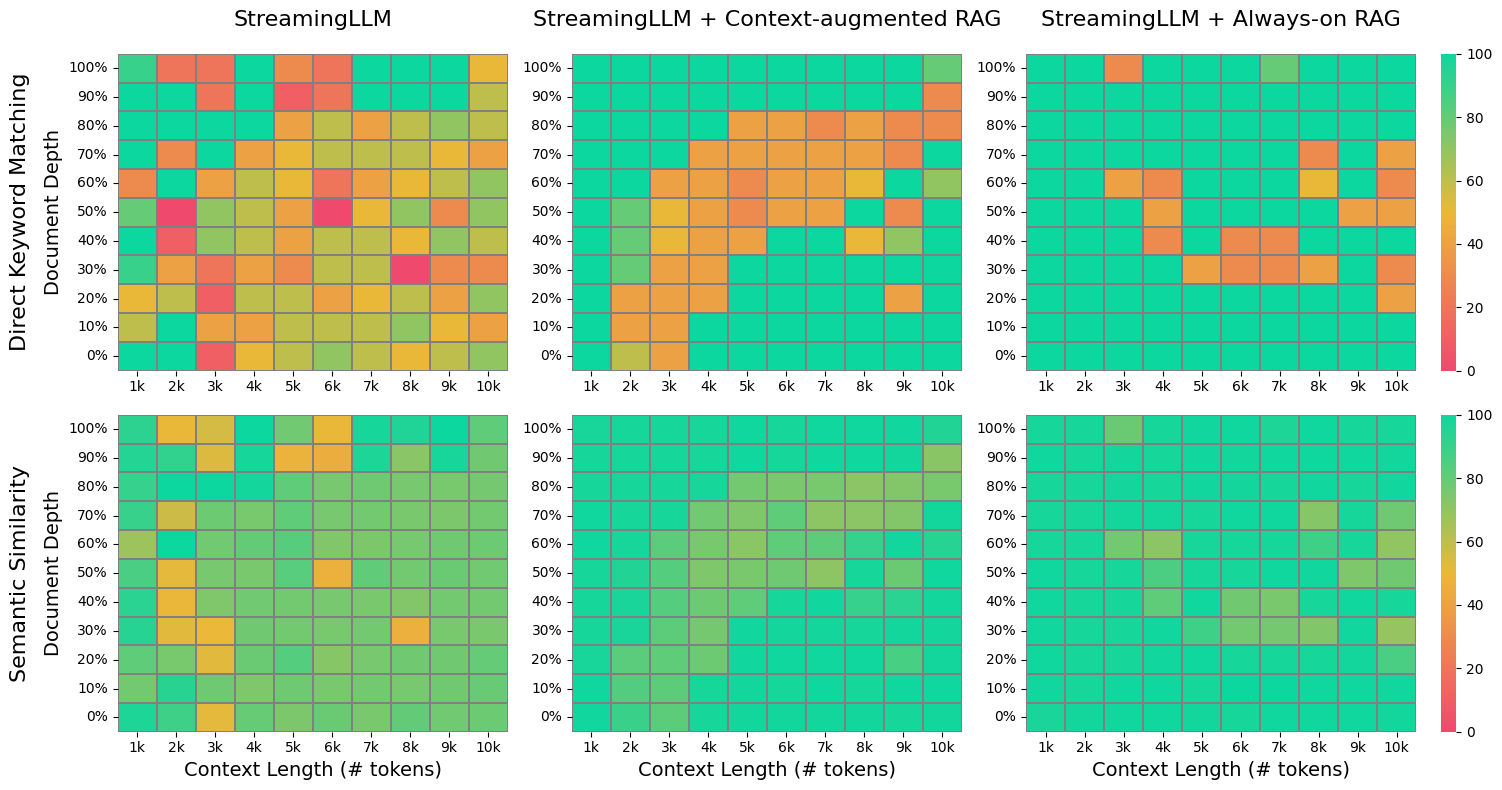

In [36]:
# If you really want to know, I found the MAGIC_RATIO by first setting it to 1,
# and computing
# w2 = axes[0,2].get_window_extent().width # width of rightmost plot
# w1 = axes[0,1].get_window_extent().width # width of middle (or left) plot
# Then the MAGIC_RATIO is w1 / w2

MAGIC_RATIO = 1.25
experiments = [
    "llama2_chunk_100_size_4096_no_retriever",
    "llama2_chunk_100_size_4096_w_retriever",
    "llama2_chunk_100_size_4096_w_always_retriever"
]
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(15, 8),
    gridspec_kw={'width_ratios': [1, 1, MAGIC_RATIO]}
)
titles = ['StreamingLLM', 'StreamingLLM + Context-augmented RAG', 'StreamingLLM + Always-on RAG']
for i in range(2):
    for j in range(3):
        experiment = experiments[j]
        results_dir = os.path.join(os.pardir, 'results', experiment)
        similarity_measure = 'dummy' if i == 0 else 'cosine'
        title = ()
        plot_accuracies(
            axes[i, j],
            results_for_plot(results_dir, similarity_measure=similarity_measure),
            enable_x_label=(i == 1),
            enable_y_label=(j == 0),
            cbar=(j == 2),
            title=(titles[j] if i == 0 else '')
        )

def add_side_title(ax, title):
    ax.text(
        -0.25,
        0.5,
        title, 
        rotation=90, 
        transform=ax.transAxes,
        size=16,
        ha='center',
        va='center'
    )

add_side_title(axes[0,0], 'Direct Keyword Matching')
add_side_title(axes[1,0], 'Semantic Similarity')

fig.show()
fig.savefig(f'test_accuracies_all.png', dpi=300, bbox_inches='tight')

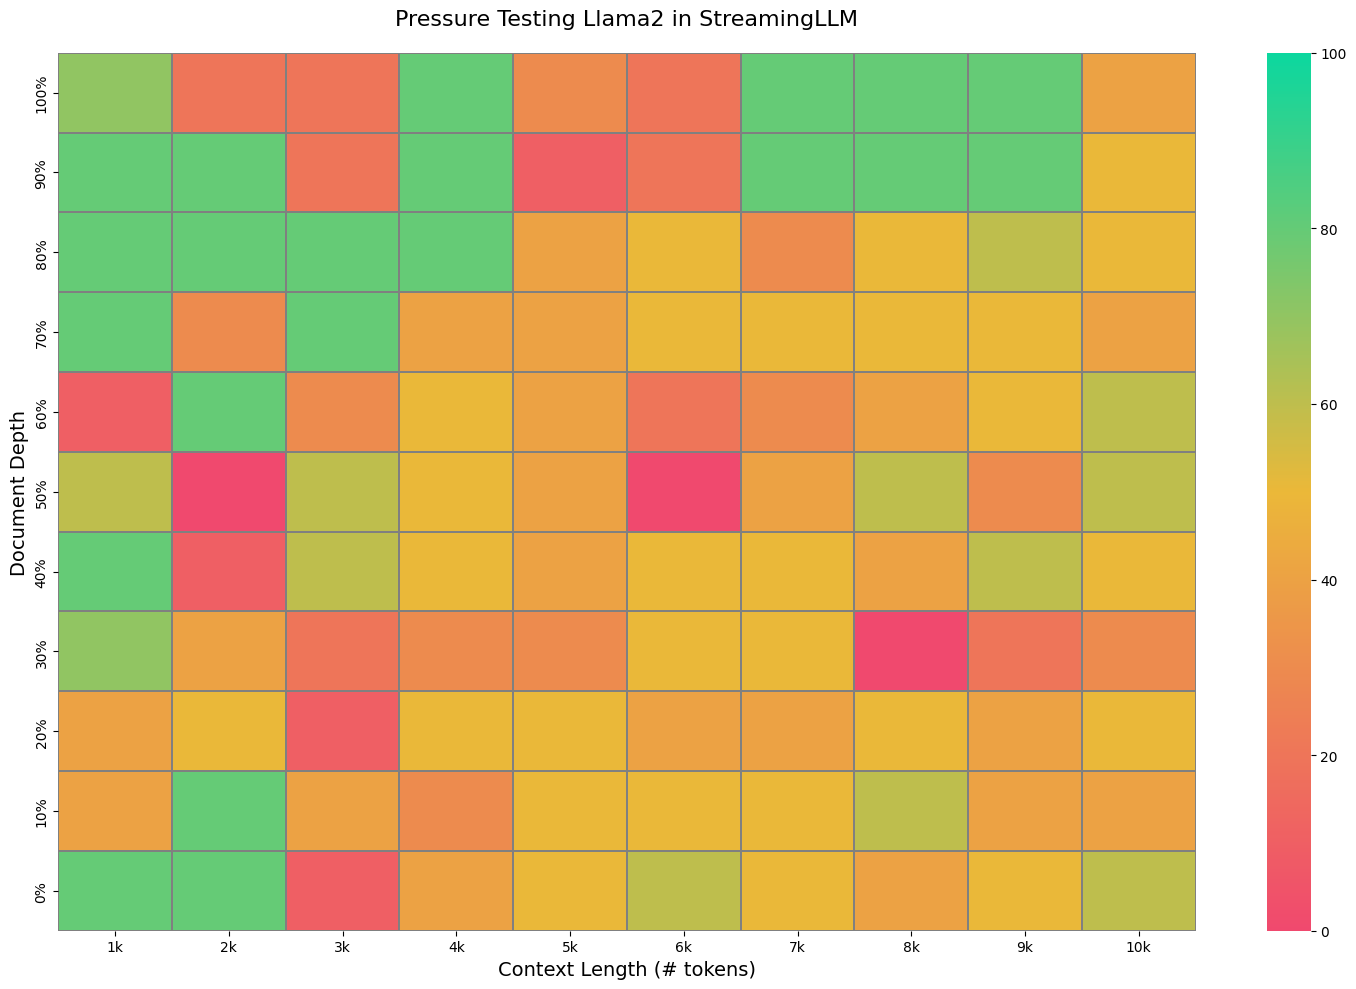

In [15]:
experiment = "llama2_chunk_100_size_4096_no_retriever"
RESULTS_DIR = os.path.join(os.pardir, 'results', experiment)
fig = plot_accuracies(results_for_plot(RESULTS_DIR), 'Pressure Testing Llama2 in StreamingLLM')
fig.savefig(f'test_accuracies_{experiment}.png', dpi=300, bbox_inches='tight')

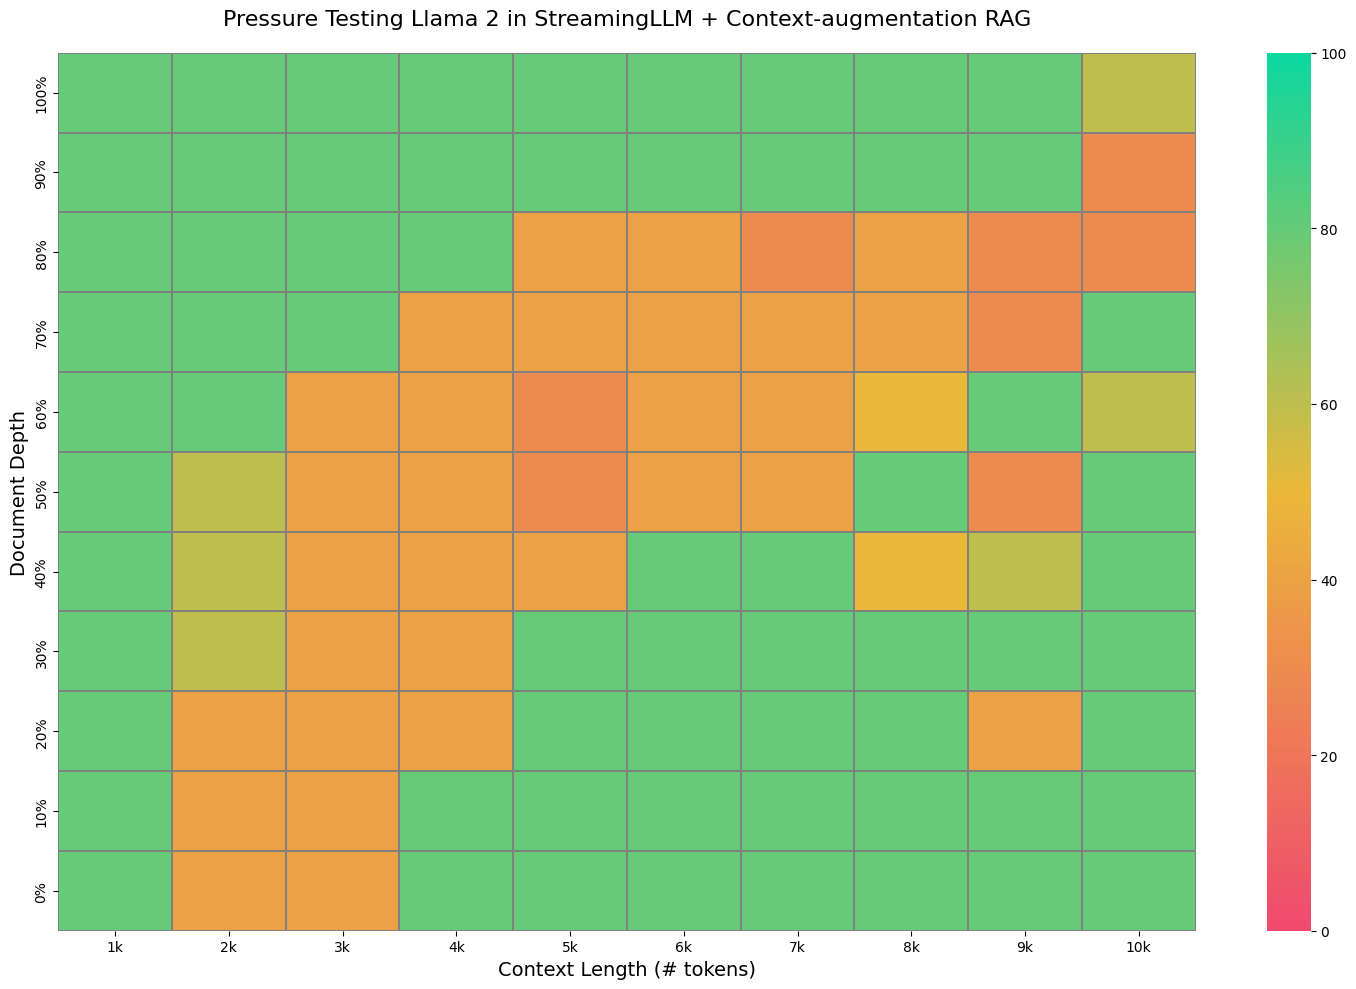

In [16]:
experiment = "llama2_chunk_100_size_4096_w_retriever"
RESULTS_DIR = os.path.join(os.pardir, 'results', experiment)
fig = plot_accuracies(results_for_plot(RESULTS_DIR), 'Pressure Testing Llama 2 in StreamingLLM + Context-augmentation RAG')
fig.savefig(f'test_accuracies_{experiment}.png', dpi=300, bbox_inches='tight')

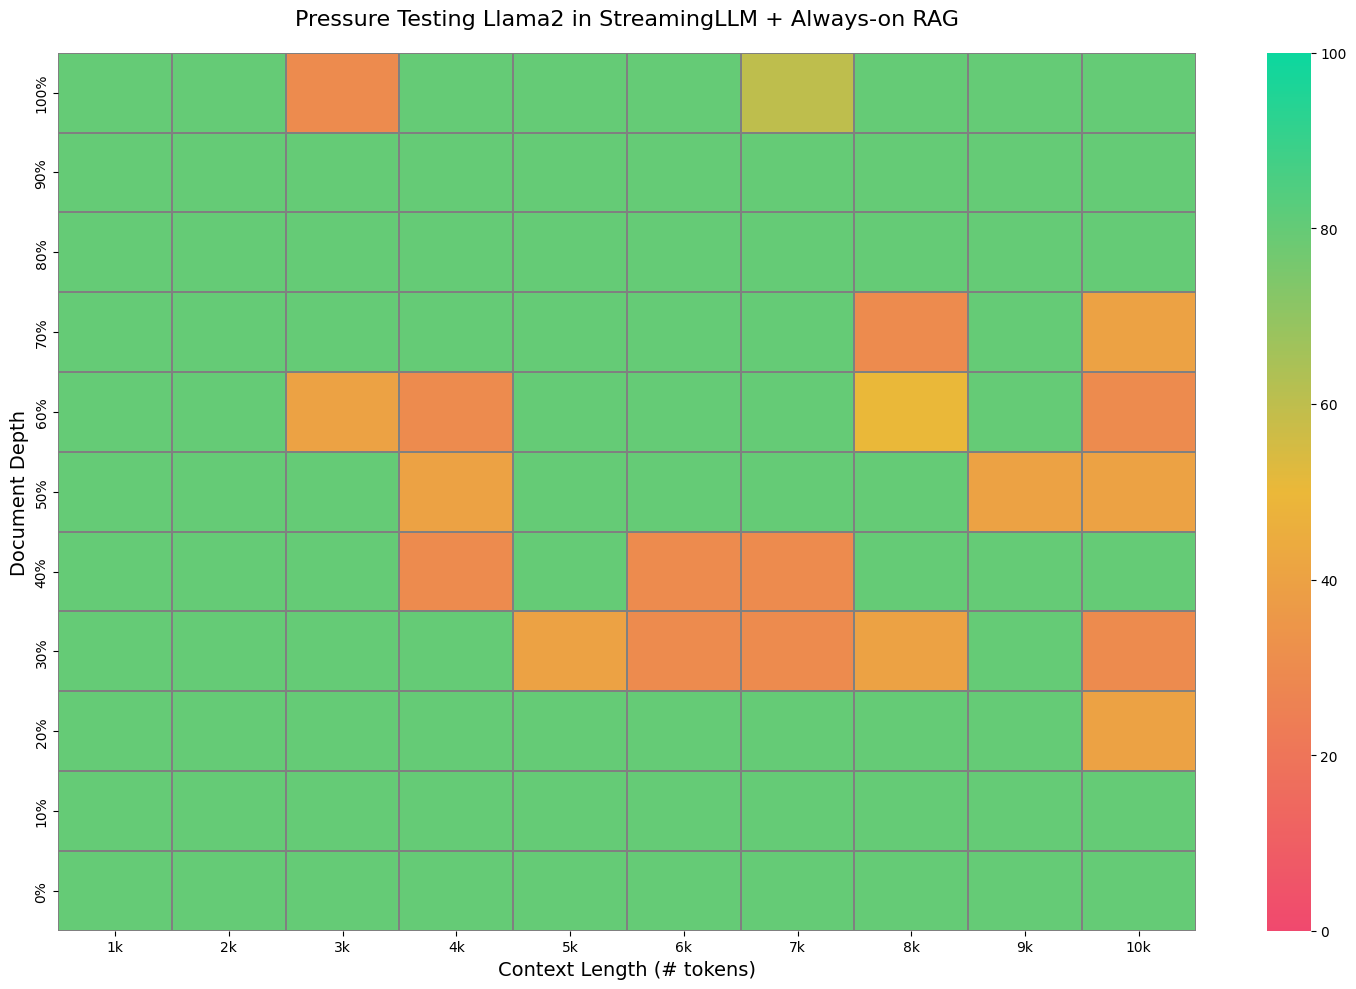

In [17]:
experiment = "llama2_chunk_100_size_4096_w_always_retriever"
RESULTS_DIR = os.path.join(os.pardir, 'results', experiment)
fig = plot_accuracies(results_for_plot(RESULTS_DIR), 'Pressure Testing Llama2 in StreamingLLM + Always-on RAG')
fig.savefig(f'test_accuracies_{experiment}.png', dpi=300, bbox_inches='tight')